# How to use the pretrained model

This Notebook shows how to load the pretrained model and use it with the fastai library

In [32]:
%load_ext autoreload
%autoreload 2

from fastai.vision import *
from PIL import Image
from matplotlib.pyplot import imshow
from pathlib import Path
from tqdm import tqdm
from skimage import io
from fastai.vision.models.xresnet import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
path = 'data/S2-allbands/crop/'

In [34]:
# Examples of labeling and custom data class for fastai

def label_for_rice(name):
    crops = (name.stem.split('-')[-1])
    
    return crops in ['B101', 'B102', 'B103']

class NPList(ImageList):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
    def open(self, fn):
        raw = np.load(str(fn))
        x = np.swapaxes(raw, 0, 2).astype(np.float32)
        return x

In [7]:
stats_eurosat_allbands = ([1353.73046875,
  1117.2020263671875,
  1041.8876953125,
  946.5513305664062,
  1199.1883544921875,
  2003.0101318359375,
  2374.01171875,
  2301.222412109375,
  732.1828002929688,
  12.099513053894043,
  1820.6893310546875,
  1118.1998291015625,
  2599.784912109375],
 [30.343395233154297,
  66.4549560546875,
  71.52734375,
  86.9700698852539,
  70.47565460205078,
  81.35286712646484,
  97.88168334960938,
  99.96805572509766,
  27.891748428344727,
  0.32882159948349,
  92.60734558105469,
  87.39993286132812,
  106.57888793945312])

In [8]:
data = NPList.from_folder(path, extensions=['.npy'])
data = data.split_by_rand_pct()
data = data.label_from_func(label_for_rice)
data = data.databunch()
data = data.normalize(stats_eurosat_allbands)

## Loading the model

In [28]:
def create_model(data,  eurosat_url='../Weights of pretrained model/Model-multispectral-0.99'):
    print('Importing custom xresnet50 pretrained on eurosat')

    model = xresnet50(c_in=13, c_out=10)
    st = torch.load(eurosat_url)
    model.load_state_dict(st)
    
    m_new = nn.Sequential(*list(model.children())[:-3], AdaptiveConcatPool2d(), Flatten(), nn.Linear(4096, 2))
    learn = Learner(data, m_new, metrics=[accuracy])
    first_layer = learn.layer_groups[0][:-4]
    second_layer = learn.layer_groups[0][-4:]
    learn.layer_groups = [first_layer, second_layer]


    return learn

In [35]:
learn = create_model(data)

Importing custom xresnet50 pretrained on eurosat


In [36]:
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [32, 32, 32]         3,744      True      
______________________________________________________________________
BatchNorm2d          [32, 32, 32]         64         True      
______________________________________________________________________
ReLU                 [2048, 2, 2]         0          False     
______________________________________________________________________
Conv2d               [32, 32, 32]         9,216      True      
______________________________________________________________________
BatchNorm2d          [32, 32, 32]         64         True      
______________________________________________________________________
ReLU                 [2048, 2, 2]         0          False     
______________________________________________________________________
Conv2d               [64, 32, 32]         18,432     True      
___________________________________________________

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


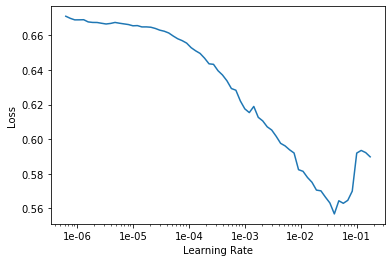

In [24]:
learn.freeze_to(-1)
learn.lr_find()
learn.recorder.plot()

In [25]:
learn.fit_one_cycle(1, slice(1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,0.579122,0.458562,0.767606,00:01


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


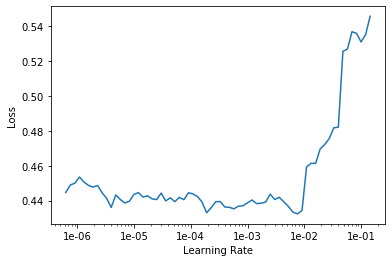

In [26]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [27]:
learn.unfreeze()
learn.fit_one_cycle(3, slice(1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.438015,0.449179,0.781690,00:01
1,0.422567,0.445989,0.792253,00:01
2,0.417002,0.449582,0.809859,00:01
